In [14]:
import pennylane as qml
import tensorflow as tf
import sklearn.datasets
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

tf.keras.backend.set_floatx('float64')

# Load & Pre-process Data set

In [67]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [68]:
def filter_01(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [69]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


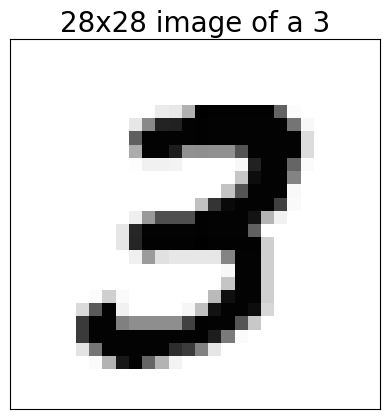

In [42]:
plt.imshow(x_train[0, :, :, 0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 3", fontsize=20)
# save to file as pdf
#plt.savefig('28x28_MNIST_.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

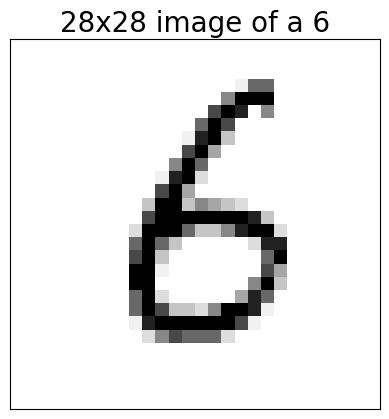

In [43]:
plt.imshow(x_train[878, :, :, :], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 6", fontsize=20)
# save to file as pdf
#plt.savefig('28x28_MNIST_3.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# Define Hinge Accuracy

In [ ]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

# Basis - Different Slices

## Horizontal Slice

In [50]:
x_train_9 = tf.image.resize(x_train, (9,9)).numpy()
x_test_9 = tf.image.resize(x_test, (9,9)).numpy()

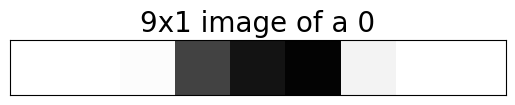

In [51]:
x_train_9 = x_train_9[:,4,:,:].reshape((-1,9))  # take only central slices
x_test_9 = x_test_9[:,4,:,:].reshape((-1,9))  # take only central slices

plt.imshow(x_train_9[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x1 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('9x1_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
n_qubits = 9
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model_hor = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_hor.predict(x_train_9[0,:])
print(model_hor.summary())

In [ ]:
model_hor.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_9.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_9
[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_9[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('Horizontal slice.log')

qnn_history_hor = model_hor.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_history_hor = model_hor.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_hor.save('Horizontal slice.h5')

### Plot

In [ ]:
plt.plot(np.arange(1,21), qnn_history_hor.history["hinge_accuracy"], label="accuracy")
plt.plot(np.arange(1,21), qnn_history_hor.history["loss"], label="loss")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("Horizontal Slice.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## Vertical Slice

In [11]:
x_train_ver_9 = tf.image.resize(x_train, (9,9)).numpy()
x_test_ver_9 = tf.image.resize(x_test, (9,9)).numpy()

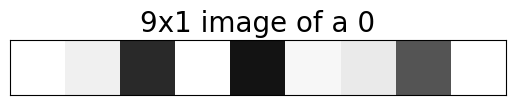

In [12]:
x_train_ver_9 = x_train_ver_9[:,:,4,:].reshape((-1,9))  # take only central slices
x_test_ver_9 = x_test_ver_9[:,:,4,:].reshape((-1,9))  # take only central slices

plt.imshow(x_train_ver_9[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x1 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('vertical slice.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
n_qubits = 9
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model_ver = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_ver.predict(x_train_ver_9[0,:])
print(model_ver.summary())

In [ ]:
model_ver.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_ver_9.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_ver_9[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_ver_9[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('Vertical slice.log')

qnn_history_ver = model_ver.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_history_ver = model_ver.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_ver.save('Vertical slice.h5')

### Plot

In [ ]:
plt.plot(np.arange(1,21), qnn_history_ver.history["hinge_accuracy"], label="accuracy")
plt.plot(np.arange(1,21), qnn_history_ver.history["loss"], label="loss")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("Vertical Slice.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## 3x3 image

In [75]:
x_train_3x3 = tf.image.resize(x_train, (3,3)).numpy()
x_train_3x3 = tf.image.resize(x_test, (3,3)).numpy()

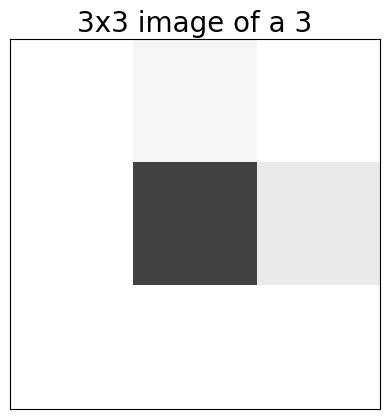

In [76]:
plt.imshow(x_train_3x3[878,:,:,0], vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("3x3 image of a 3", fontsize=20)
# save to file as pdf
#plt.savefig('9x9_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

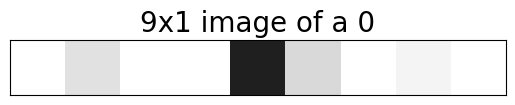

In [77]:
x_train_3x3 = x_train_3x3[:].reshape((-1,9))  # take only central slices
x_train_3x3 = x_train_3x3[:].reshape((-1,9))  # take only central slices

plt.imshow(x_train_3x3[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x1 image of a 0", fontsize=20)
#save to file as pdf
#plt.savefig('9x1_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
n_qubits = 9
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model_3x3 = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_3x3.predict(x_train_3x3[0,:])
print(model_3x3.summary())

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_3x3.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_s3x3[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_3x3[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('3x3 slice.log')

qnn_history_3x3 = model_3x3.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_history_3x3 = model_3x3.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_3x3.save('3x3.h5')

### Plot

In [ ]:
plt.plot(np.arange(1,21), qnn_history_3x3.history["hinge_accuracy"], label="accuracy")
plt.plot(np.arange(1,21), qnn_history_3x3.history["loss"], label="loss")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("3x3.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# Encoding Methods

## 1 - Layer

### Basis

In [ ]:
n_qubits = 9
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model_basis = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_basis.predict(x_train_9[0,:])
print(model_basis.summary())

In [ ]:
model_basis.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_9.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_9[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_9[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_basis_1layer.log')


qnn_history_basis_1layer = model_basis.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_basis_1layer = model_basis.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_basis.save('Basis-1Layer.h5')

### Amplitude

#### Process full image

In [ ]:
x_train_28 = x_train[:,:,:,:].reshape((-1,784))  # take only central slices
x_test_28 = x_test[:,:,:,:].reshape((-1,784))  # take only central slices

plt.imshow(x_train_28[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("784x1 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('784x1_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
n_qubits = 10
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    #print(len(inputs))
    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
#print(inputs)
outputs = qlayer(inputs)
model_amp = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_amp.predict(x_train_28[0,:].reshape(1, -1))
print(model_amp.summary())

In [ ]:
model_amp.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_amp_1layer.log')

qnn_history_amp_1layer = model_amp.fit(
      x_train_sub, y_train_hinge_sub,callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_amp_1layer = model_amp.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_amp.save('Amp-1Layer.h5')

### FRQI

#### Get FRQI pixels

In [ ]:
def frqi(img_array):
    frqi = []
    for pixel in img_array:
        frqi.extend([(1/math.sqrt(2))*np.cos(pixel), (1/math.sqrt(2))*np.sin(pixel)])
        
    frqi_arr = np.array(frqi)
    return frqi_arr

In [ ]:
x_train_frqi = []
for image in x_train_28:
    arr = frqi(image)
    x_train_frqi.append(arr)
    
x_train_frqi = np.array(x_train_frqi)

In [ ]:
x_test_frqi = []
for image in x_test_28:
    arr = frqi(image)
    x_test_frqi.append(arr)
    
x_test_frqi = np.array(x_test_frqi)

In [ ]:
n_qubits = 11
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    #print(len(inputs))
    qml.AmplitudeEmbedding(inputs, wires=range(11), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(1568,), name="inputs")
#print(inputs)
outputs = qlayer(inputs)
model_frqi = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_frqi.predict(x_train_frqi[0,:].reshape(1, -1))
print(model_frqi.summary())

In [ ]:
model_frqi.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]

x_train_sub = x_train_frqi[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_frqi[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_frqi_1layer.log')

qnn_history_frqi_1layer = model_frqi.fit(
      x_train_sub, y_train_hinge_sub,callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_frqi_1layer = model_frqi.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_frqi.save('frqi-1Layer.h5')

### Plot

In [15]:
qnn_history_basis_1layer = pd.read_csv('qnn_history_basis_1layer.log')
qnn_history_amp_1layer = pd.read_csv('qnn_history_amp_1layer.log')
qnn_history_frqi_1layer = pd.read_csv('qnn_history_frqi_1layer.log')

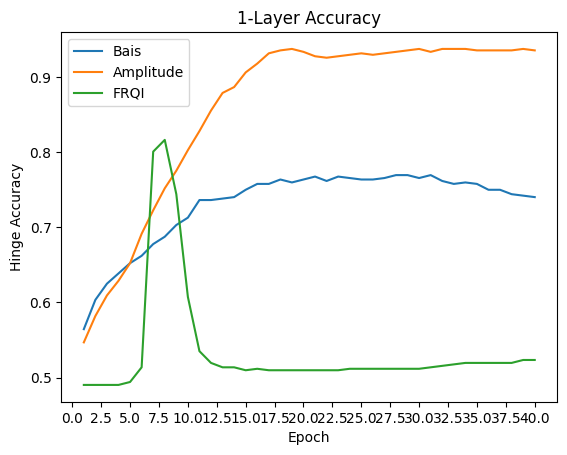

In [17]:
plt.plot(np.arange(1,41), qnn_history_basis_1layer["hinge_accuracy"], label="Bais")
plt.plot(np.arange(1,41), qnn_history_amp_1layer["hinge_accuracy"], label="Amplitude")
plt.plot(np.arange(1,41), qnn_history_frqi_1layer["hinge_accuracy"], label="FRQI")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.title("1-Layer Accuracy")
plt.legend()
# modify x_tic  ks to also include 20
plt.xticks(np.arange(0, 41, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("frqi-Amp-Basis acc 1Layer.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

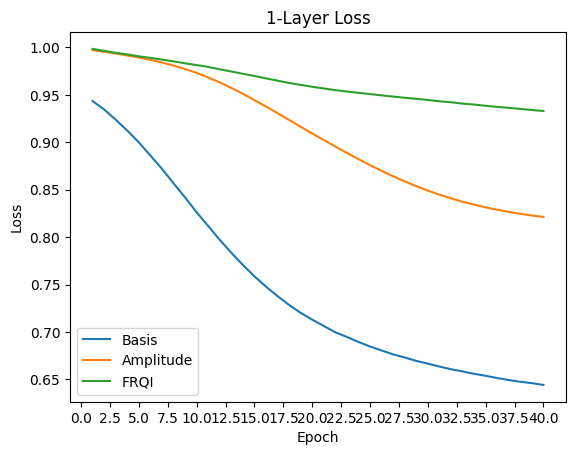

In [18]:
plt.plot(np.arange(1,41), qnn_history_basis_1layer["loss"], label="Basis")
plt.plot(np.arange(1,41), qnn_history_amp_1layer["loss"], label="Amplitude")
plt.plot(np.arange(1,41), qnn_history_frqi_1layer["loss"], label="FRQI")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("1-Layer Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 41, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("Frqi-Amp-Basis loss 1Layer.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## 2- Layer

### Basis

In [ ]:
n_qubits = 9
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model2_basis = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2_basis.predict(x_train_9[0,:])
print(model2_basis.summary())o

In [ ]:
model2_basis.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_9[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_9[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_basis_2layer.log')

qnn_history_basis_2layer = model2_basis.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_basis_2layer = model2_basis.evaluate(x_test_sub, y_test_sub)

In [ ]:
model2_basis.save('Basis-2Layer.h5')

### Amplitude

In [ ]:
n_qubits = 10
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model2_amp = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2_amp.predict(x_train_28[0,:].reshape(1, -1))
print(model2_amp.summary())

In [ ]:
model2_amp.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_amp_2layer.log')

qnn_history_amp_2layer = model2_amp.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_amp_2layer = model2_amp.evaluate(x_test_sub, y_test_sub)

In [ ]:
model2_amp.save('Amp-2Layer.h5')

### FRQI

In [ ]:
n_qubits = 11
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    #print(len(inputs))
    qml.AmplitudeEmbedding(inputs, wires=range(11), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(1568,), name="inputs")
#print(inputs)
outputs = qlayer(inputs)
model2_frqi = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2_frqi.predict(x_train_frqi[0,:].reshape(1, -1))
print(model2_frqi.summary())

In [ ]:
model2_frqi.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]

x_train_sub = x_train_frqi[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_frqi[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_frqi_2layer.log')

qnn_history_frqi_2layer = model2_frqi.fit(
      x_train_sub, y_train_hinge_sub,callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_frqi_2layer = model2_frqi.evaluate(x_test_sub, y_test_sub)

In [ ]:
model2_frqi.save('frqi-2Layer.h5')

### Plot

In [19]:
qnn_history_basis_2layer = pd.read_csv('qnn_history_basis_2layer.log')
qnn_history_amp_2layer = pd.read_csv('qnn_history_amp_2layer.log')
qnn_history_frqi_2layer = pd.read_csv('qnn_history_frqi_2layer.log')

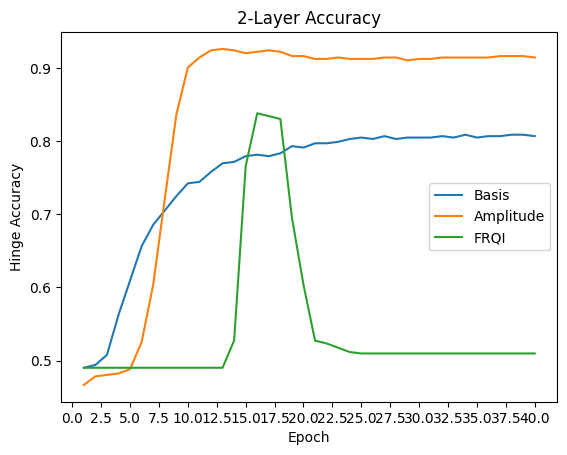

In [21]:
plt.plot(np.arange(1,41), qnn_history_basis_2layer["hinge_accuracy"], label="Basis")
plt.plot(np.arange(1,41), qnn_history_amp_2layer["hinge_accuracy"], label="Amplitude")
plt.plot(np.arange(1,41), qnn_history_frqi_2layer["hinge_accuracy"], label="FRQI")

plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.title("2-Layer Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 41, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("Frqi-Amp-Basis acc 2Layer.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

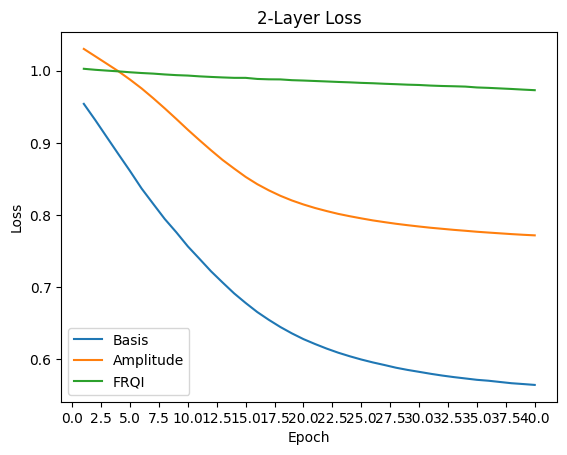

In [23]:
plt.plot(np.arange(1,41), qnn_history_basis_2layer["loss"], label="Basis")
plt.plot(np.arange(1,41), qnn_history_amp_2layer["loss"], label="Amplitude")
plt.plot(np.arange(1,41), qnn_history_frqi_2layer["loss"], label="FRQI")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("2-Layer Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 41, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("Frqi-Amp-Basis loss 2Layer.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## 3-Layer

### Basis

In [ ]:
n_qubits = 9
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model3_basis = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model3_basis.predict(x_train_9[0,:])
print(model3_basis.summary())

In [ ]:
model3_basis.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_9[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_9[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_basis_3layer.log')

qnn_history_basis_3layer = model3_basis.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_basis_3layer = model3_basis.evaluate(x_test_sub, y_test_sub)

In [ ]:
model3_basis.save('Basis-3Layer.h5')

### Amplitude

In [ ]:
n_qubits = 10
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model3_amp = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model3_amp.predict(x_train_28[0,:].reshape(1, -1))
print(model3_amp.summary())

In [ ]:
model3_amp.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_amp_3layer.log')

qnn_history_amp_3layer = model3_amp.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_amp_3layer = model3_amp.evaluate(x_test_sub, y_test_sub)

In [ ]:
model3_amp.save('Amp-3Layer.h5')

### FRQI

In [ ]:
n_qubits = 11
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    #print(len(inputs))
    qml.AmplitudeEmbedding(inputs, wires=range(11), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(1568,), name="inputs")
#print(inputs)
outputs = qlayer(inputs)
model3_frqi = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model3_frqi.predict(x_train_frqi[0,:].reshape(1, -1))
print(model3_frqi.summary())

In [ ]:
model3_frqi.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 40
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]

x_train_sub = x_train_frqi[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_frqi[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_frqi_3layer.log')

qnn_history_frqi_3layer = model3_frqi.fit(
      x_train_sub, y_train_hinge_sub,callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_frqi_3layer = model3_frqi.evaluate(x_test_sub, y_test_sub)

In [ ]:
model3_frqi.save('Frqi-3Layer.h5')

### Plot

In [25]:
qnn_history_basis_3layer = pd.read_csv('qnn_history_basis_3layer.log')
qnn_history_amp_3layer = pd.read_csv('qnn_history_amp_3layer.log')
qnn_history_frqi_3layer = pd.read_csv('qnn_history_frqi_3layer.log')

In [ ]:
plt.plot(np.arange(1,41), qnn_history_basis_3layer["hinge_accuracy"], label="Basis")
plt.plot(np.arange(1,41), qnn_history_amp_3layer["hinge_accuracy"], label="Amplitude")
plt.plot(np.arange(1,41), qnn_history_frqi_3layer["hinge_accuracy"], label="FRQI")

plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.title("3-Layer Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 41, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("Frqi-Amp-Basis acc 3Layer.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
plt.plot(np.arange(1,41), qnn_history_basis_3layer["loss"], label="Basis")
plt.plot(np.arange(1,41), qnn_history_amp_3layer["loss"], label="Amplitude")
plt.plot(np.arange(1,41), qnn_history_frqi_3layer["loss"], label="FRQI")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("3-Layer Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 41, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("Frqi-Amp-Basis loss 3Layer.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# Optimisation

## 2 Layer Amplitude encoding

### Adjoint Adam

In [ ]:
n_qubits = 10
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model.predict(x_train_28[0,:].reshape(1, -1))
print(model.summary())

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('adj-adam.log')

qnn_history = model.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_history = model.evaluate(x_test_sub, y_test_sub)

In [ ]:
model.save('adjoint-adam.h5')

### Adjoint - GradientDescentOptimizer

In [ ]:
n_qubits = 10
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2.predict(x_train_28[0,:].reshape(1, -1))
print(model2.summary())

In [ ]:
model2.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('adj-sgd.log')

qnn2_history = model2.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn2_history = model2.evaluate(x_test_sub, y_test_sub)

In [ ]:
model2.save('adjoint-sgd.h5')

### Finite difference - GradientDescentOptimizer

In [ ]:
n_qubits = 10
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="finite-diff")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model3 = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model3.predict(x_train_28[0,:].reshape(1, -1))
print(model3.summary())

In [ ]:
model3.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('finitediff-sgd.log')

qnn3_history = model3.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn3_history = model3.evaluate(x_test_sub, y_test_sub)

### Parameter shift - GradientDescentOptimizer

In [ ]:
n_qubits = 10
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="parameter-shift")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model4 = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model4.predict(x_train_28[0,:].reshape(1, -1))
print(model4.summary())

In [ ]:
model4.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('paramshift-sgd.log')

qnn4_history = model4.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn4_history = model4.evaluate(x_test_sub, y_test_sub)

In [ ]:
model4.save('paramshift-sgd.h5')

### SPSA

In [ ]:
n_qubits = 10
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    #print(inputs)
    #print(weights)
    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model_spsa = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_spsa.predict(x_train_28[0,:].reshape(1, -1))
print(model_spsa.summary())

In [ ]:
from pennylane.optimize import SPSAOptimizer
opt = qml.SPSAOptimizer(maxiter=200, c=0.15, a=0.2)
#model_spsa.compile(loss='mse', optimizer=opt)
model_spsa.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer= opt,
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('spsa.log')

qnn_spsa_history = model_spsa.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_spsa_history = model_spsa.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_spsa.save('spsa.h5')

### Plot

In [28]:
qnn_history = pd.read_csv('adj-adam.log')
qnn2_history = pd.read_csv('adj-sgd.log')
qnn3_history = pd.read_csv('finitediff-sgd.log')
qnn4_history = pd.read_csv('paramshift-sgd.log')

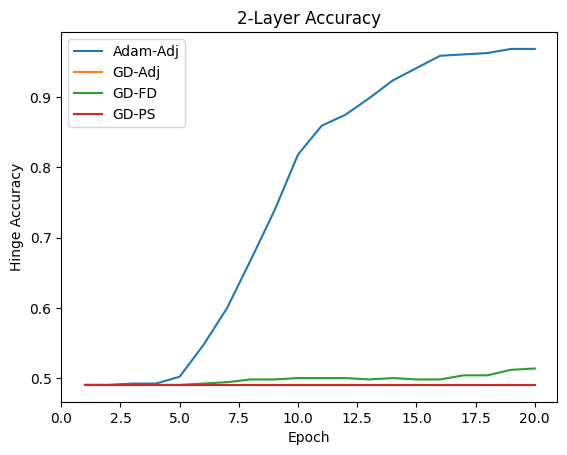

In [29]:
plt.plot(np.arange(1,21), qnn_history["hinge_accuracy"], label="Adam-Adj")
plt.plot(np.arange(1,21), qnn2_history["hinge_accuracy"], label="GD-Adj")
plt.plot(np.arange(1,21), qnn3_history["hinge_accuracy"], label="GD-FD")
plt.plot(np.arange(1,21), qnn4_history["hinge_accuracy"], label="GD-PS")
#plt.plot(np.arange(1,21), qnn_spsa_history.history["hinge_accuracy"], label="SPSA")

plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.title("2-Layer Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("optimisation amp acc 2Layer.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

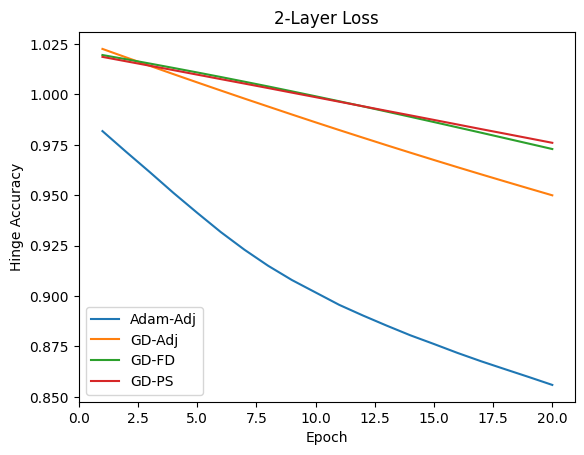

In [30]:
plt.plot(np.arange(1,21), qnn_history["loss"], label="Adam-Adj")
plt.plot(np.arange(1,21), qnn2_history["loss"], label="GD-Adj")
plt.plot(np.arange(1,21), qnn3_history["loss"], label="GD-FD")
plt.plot(np.arange(1,21), qnn4_history["loss"], label="GD-PS")
#plt.plot(np.arange(1,21), qnn_spsa_history.history["hinge_accuracy"], label="SPSA")

plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.title("2-Layer Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("optimisation amp loss 2Layer.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# New Ansatz - with U3 gates

## Basis Encoding with Adjoin and Adam optimization

### Layer - 1

In [ ]:
n_qubits = 9
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):
    
    #print('inputs:', inputs)
    #print('weights:', weights)
    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        #qml.RZ(weights[jj,2*ii,0], wires=0)
        #qml.RY(weights[jj,2*ii,1], wires=0)
        #qml.RZ(weights[jj,2*ii,2], wires=0)
        for ii in range(n_qubits):
            qml.RZ(weights[jj, 2*ii,0], wires=ii)
            qml.RY(weights[jj, 2*ii,1], wires=ii)
            qml.RZ(weights[jj, 2*ii,2], wires=ii)

            #qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            #qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            #qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
        for kk in range(n_qubits-1):
            if(kk%2 == 0):
                qml.CNOT(wires=[kk+1,kk])
            
    for ii in range(n_qubits):
        qml.RZ(weights[jj,2*ii+1,0], wires=ii)
        qml.RY(weights[jj,2*ii+1,1], wires=ii)
        qml.RZ(weights[jj,2*ii+1,2], wires=ii)

    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7)@qml.PauliZ(8))

weight_shapes = {"weights": (n_layers, 2*(n_qubits)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model_ansatz = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_ansatz.predict(x_train_9[0,:])
print(model_ansatz.summary())

In [ ]:
# Assigning random weight to visualize the circuit

weights = np.array(
[[[-1.97528251e-01, -2.90917986e-01,  4.31702285e-01],
  [ 3.68390797e-01,  3.58216676e-01,  3.16676838e-01],
  [-3.26563673e-01,  1.73288683e-01,  3.72691217e-01],
  [ 2.98967097e-01,  1.81081164e-01, -4.22713839e-01],
  [-1.26261285e-02, -5.01598451e-01,  3.85237322e-02],
  [-2.14257384e-01, -7.72885138e-02,  3.86160415e-01],
  [-1.15142197e-01,  2.09132015e-01, -1.13619990e-01],
  [-4.48743682e-01, -1.58241141e-01,  2.59955642e-01],
  [ 3.56385748e-01, -4.82744807e-01,  2.79063232e-01],
  [-1.93409416e-01,  4.36492955e-01,  2.05616640e-01],
  [ 2.62269357e-01, -2.07848602e-01, -2.65048983e-01],
  [ 4.22407367e-01,  4.64575593e-04,  3.10098349e-01],
  [ 1.17151506e-01,  3.45164850e-01, -5.23165612e-01],
  [-3.53538048e-01,  4.76818496e-01, -3.94650586e-01],
  [ 1.96646715e-01,  3.05178758e-01,  3.76644920e-01],
  [-4.66803263e-01,  3.26115091e-01, -2.33166846e-01],
  [ 1.64767668e-01, -2.44926121e-01, -3.05480053e-01],
  [ 0.4716368,      -0.32745629,     -0.30282775],
  [ 0.40533588,      0.12210432,      0.39164872]]])

drawer = qml.draw(qnode, show_all_wires=True)
print(drawer(x_train_9[0,:], weights))

In [ ]:
model_ansatz.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_9[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_9[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('ansatz layer 1.log')

qnn_ansatz_history = model_ansatz.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_sub, y_test_sub))

qnn_ansatz_history = model_ansatz.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_ansatz.save('ansatz layer 1.h5')

### 2 - Layer

In [ ]:
n_qubits = 9
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):
    
    #print('inputs:', inputs)
    #print('weights:', weights)
    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        #qml.RZ(weights[jj,2*ii,0], wires=0)
        #qml.RY(weights[jj,2*ii,1], wires=0)
        #qml.RZ(weights[jj,2*ii,2], wires=0)
        for ii in range(n_qubits):
            qml.RZ(weights[jj, 2*ii,0], wires=ii)
            qml.RY(weights[jj, 2*ii,1], wires=ii)
            qml.RZ(weights[jj, 2*ii,2], wires=ii)

            #qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            #qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            #qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
        for kk in range(n_qubits-1):
            if(kk%2 == 0):
                qml.CNOT(wires=[kk+1,kk])
            
    for ii in range(n_qubits):
        qml.RZ(weights[jj,2*ii+1,0], wires=ii)
        qml.RY(weights[jj,2*ii+1,1], wires=ii)
        qml.RZ(weights[jj,2*ii+1,2], wires=ii)

    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7)@qml.PauliZ(8))

weight_shapes = {"weights": (n_layers, 2*(n_qubits)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model2_ansatz = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2_ansatz.predict(x_train_9[0,:])
print(model2_ansatz.summary())

In [ ]:
model2_ansatz.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_9[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_9[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('ansatz layer 2.log')

qnn2_ansatz_history = model2_ansatz.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_sub, y_test_sub))

qnn2_ansatz_history = model2_ansatz.evaluate(x_test_sub, y_test_sub)

In [ ]:
model2_ansatz.save('ansatz layer 2.h5')

### 3 - Layer

In [ ]:
n_qubits = 9
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):
    
    #print('inputs:', inputs)
    #print('weights:', weights)
    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        #qml.RZ(weights[jj,2*ii,0], wires=0)
        #qml.RY(weights[jj,2*ii,1], wires=0)
        #qml.RZ(weights[jj,2*ii,2], wires=0)
        for ii in range(n_qubits):
            qml.RZ(weights[jj, 2*ii,0], wires=ii)
            qml.RY(weights[jj, 2*ii,1], wires=ii)
            qml.RZ(weights[jj, 2*ii,2], wires=ii)

            #qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            #qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            #qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
        for kk in range(n_qubits-1):
            if(kk%2 == 0):
                qml.CNOT(wires=[kk+1,kk])
            
    for ii in range(n_qubits):
        qml.RZ(weights[jj,2*ii+1,0], wires=ii)
        qml.RY(weights[jj,2*ii+1,1], wires=ii)
        qml.RZ(weights[jj,2*ii+1,2], wires=ii)

    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7)@qml.PauliZ(8))

weight_shapes = {"weights": (n_layers, 2*(n_qubits)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model3_ansatz = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model3_ansatz.predict(x_train_9[0,:])
print(model3.summary())

In [ ]:
model3_ansatz.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_9[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_9[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('ansatz layer 3.log')

qnn3_ansatz_history = model3_ansatz.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_sub, y_test_sub))

qnn3_ansatz_history = model3_ansatz.evaluate(x_test_sub, y_test_sub)

In [ ]:
model3_ansatz.save('ansatz layer 3.h5')

### Plot

In [ ]:
qnn_ansatz_history = pd.read_csv('ansatz layer 1.log')
qnn2_ansatz_history = pd.read_csv('ansatz layer 2.log')
qnn3_ansatz_history = pd.read_csv('ansatz layer 3.log')

In [ ]:
plt.plot(np.arange(1,21), qnn_ansatz_history["hinge_accuracy"], label="layer 1")
plt.plot(np.arange(1,21), qnn2_ansatz_history["hinge_accuracy"], label="layer 2")
plt.plot(np.arange(1,21), qnn3_ansatz_history["hinge_accuracy"], label="layer 3")


plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.title("New ansatz Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("new anstaz basis adj adam acc.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
plt.plot(np.arange(1,21), qnn_ansatz_history["loss"], label="layer 1")
plt.plot(np.arange(1,21), qnn2_ansatz_history["loss"], label="layer 2")
plt.plot(np.arange(1,21), qnn3_ansatz_history["loss"], label="layer 3")


plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.title("Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("new anstaz basis adj adam loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# CNN-QNN Hybrid Ansatz

## Amplitude Encoding with Adjoint and Adam optimisation

### 1 - Layer

In [ ]:
n_qubits = 10
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    #print(len(inputs))
    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim= n_qubits, name="quantumLayer")

clayer_1 = tf.keras.layers.Dense(4)
clayer_2 = tf.keras.layers.Dense(1, activation="softmax")

inputs = tf.keras.Input(shape=(784,), name="inputs")

x = clayer_1(inputs)
x = qlayer(x)
outputs = clayer_2(x)

#print(inputs)
outputs = qlayer(inputs)
model_hybrid = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model_hybrid.predict(x_train_28[0,:].reshape(1, -1))
print(model_hybrid.summary())

model_hybrid.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_anstaz_1layer.log')

qnn_history_hybrid_1layer = model_amp.fit(
      x_train_sub, y_train_hinge_sub,callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_hybrid_1layer = model_hybrid.evaluate(x_test_sub, y_test_sub)

In [ ]:
model_hybrid.save('hybrid-anstaz-1Layer.h5')

### 2 - Layer

In [ ]:
n_qubits = 10
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim= n_qubits, name="quantumLayer")

clayer_1 = tf.keras.layers.Dense(4)
clayer_2 = tf.keras.layers.Dense(1, activation="softmax")

inputs = tf.keras.Input(shape=(784,), name="inputs")

x = clayer_1(inputs)
x = qlayer(x)
outputs = clayer_2(x)

#print(inputs)
outputs = qlayer(inputs)
model2_hybrid = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2_hybrid.save('hybrid-anstaz-2Layer.h5').predict(x_train_28[0,:].reshape(1, -1))
print(model2_hybrid.summary())

In [ ]:
model2_hybrid.save('hybrid-anstaz-2Layer.h5').compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_anstaz_2layer.log')

qnn_history_hybrid_2layer = model2_hybrid.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_hybrid_2layer = model2_hybrid.evaluate(x_test_sub, y_test_sub)

In [ ]:
model2_hybrid.save('hybrid-anstaz-2Layer.h5')

### 3 - Layer

In [ ]:
n_qubits = 10
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(inputs, wires=range(10), pad_with=0.0, normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim= n_qubits, name="quantumLayer")

clayer_1 = tf.keras.layers.Dense(4)
clayer_2 = tf.keras.layers.Dense(1, activation="softmax")

inputs = tf.keras.Input(shape=(784,), name="inputs")

x = clayer_1(inputs)
x = qlayer(x)
outputs = clayer_2(x)

#print(inputs)
outputs = qlayer(inputs)
model3_hybrid = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model3_hybrid.predict(x_train_28[0,:].reshape(1, -1))
print(model3_hybrid.summary())

In [ ]:
model3_hybrid.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_28[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_28[:,:]
y_test_sub = y_test[:]

csv_logger = CSVLogger('qnn_history_anstaz_3layer.log')

qnn_history_hybrid_3layer = model3_hybrid.fit(
      x_train_sub, y_train_hinge_sub, callbacks=[csv_logger],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

qnn_results_hybrid_3layer = model3_hybrid.evaluate(x_test_sub, y_test_sub)

In [ ]:
model3_amp.save('anstaz-3Layer.h5')

### Plot

In [33]:
qnn_history_hybrid_1layer = pd.read_csv('qnn_history_anstaz_1layer.log')
qnn_history_hybrid_2layer = pd.read_csv('qnn_history_anstaz_2layer.log')
qnn_history_hybrid_3layer = pd.read_csv('qnn_history_anstaz_3layer.log')

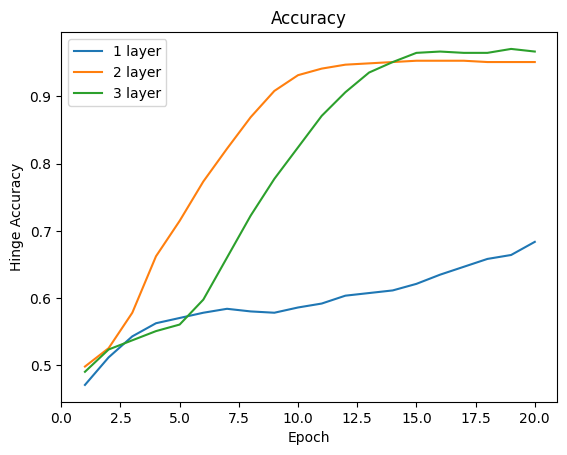

In [35]:
plt.plot(np.arange(1,21), qnn_history_hybrid_1layer["hinge_accuracy"], label="1 layer")
plt.plot(np.arange(1,21), qnn_history_hybrid_2layer["hinge_accuracy"], label="2 layer")
plt.plot(np.arange(1,21), qnn_history_hybrid_3layer["hinge_accuracy"], label="3 layer")

plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.title("Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("new anstaz-accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

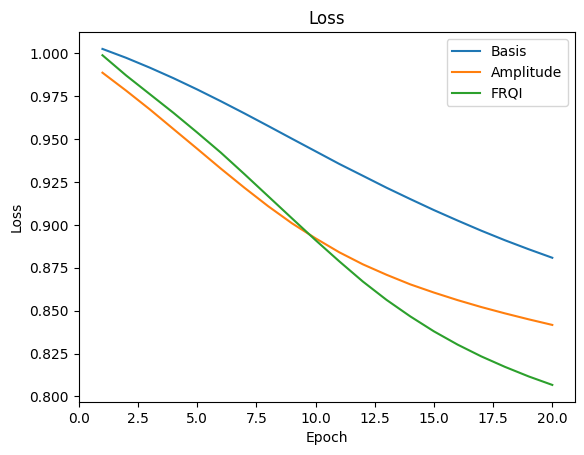

In [36]:
plt.plot(np.arange(1,21), qnn_history_hybrid_1layer["loss"], label="Basis")
plt.plot(np.arange(1,21), qnn_history_hybrid_2layer["loss"], label="Amplitude")
plt.plot(np.arange(1,21), qnn_history_hybrid_3layer["loss"], label="FRQI")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("new anstaz-loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()